# Kaggle's MNIST

## Initialization & imports

In [1]:
#import sys, itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from skimage import transform as trf, util as iutil
from scipy import ndimage

from mnist_helpers import plot_multiclass_roc_curve

from IPython.display import display, Markdown

## Pandas & seaborn config

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('chained_assignment', None)

sns.set(style="dark", palette="hls")

## CSV reading

In [3]:
print "Reading CSV..."
df = pd.read_csv("../data/input/train.csv")

Reading CSV...


## Options

In [4]:
opt_dataset_augment = False
opt_pca_knn = True
# Output
display(Markdown("Classifier: KNN with PCA" if opt_pca_knn else "Classifier: Random Forest"))

Classifier: KNN with PCA

## Features & labels

In [5]:
labels   = ['label']
features =  df.columns.drop(labels).values.tolist()

## Data exploration

In [6]:
display(Markdown("### Info"))
print df.info()
display(Markdown("### Null counts"))
print df.isnull().sum(axis=0).nonzero()

### Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


### Null counts

(array([], dtype=int64),)


## Image display function

In [7]:
def show_imgs(X, y, num=20):
    fig, axes = plt.subplots(1, num, figsize=(16,16))
    for i in range (0, num):
        label = y[i]
        img   = X.iloc[i].values.reshape(28,28)
        axes[i].imshow(img, cmap="Purples")
        axes[i].set_title(label)
        axes[i].axis('off')

## Image exploration

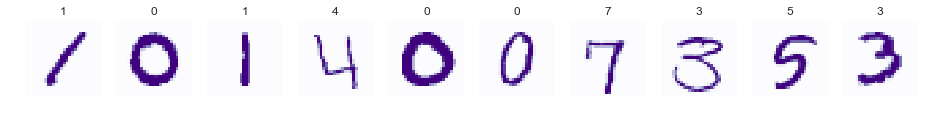

In [8]:
show_imgs(df.drop(columns=labels), df[labels].values.ravel(), 10)

## Dataset augmentation

In [9]:
def transform_image(img):
    img = ndimage.rotate(img, np.random.randint(-15, 15), order=1, reshape=False)
    img = ndimage.shift(img, np.random.randint(-2, 2), order=1)
    #img = trf.swirl(img, strength=np.random.randint(-2, 2))
    #img = trf.downscale_local_mean(img, (1,1))
    #img = trf.resize(img, (28, 28), order=1, preserve_range=True)
    #img = iutil.crop(img, 28)
    return img

def transform_vectorimage(row):
    #imgsize = (28,28)
    row = row.values.reshape(28,28)
    row = transform_image(row)
    row = row.reshape(28*28)
    return row

if (opt_dataset_augment):
    sample = df.sample(frac=0.5, random_state=33)
    y_add  = sample[labels]
    X_add  = sample.drop(columns=labels).apply(transform_vectorimage, axis=1)

    show_imgs(sample.drop(columns=labels), y_add.values.ravel(), 20)

    X_add = X_add.assign(label=y_add)
    show_imgs(X_add.drop(columns=labels), X_add[labels].values.ravel(), 20)

    df = df.append(X_add[df.columns], ignore_index=True) #X_add[df.columns] keeps column order
    print "augmenting dataset with %i rows, total = %i" % (X_add.shape[0], df.shape[0])

## Preprocess

In [10]:
# Assigning
y = df[labels]
X = df.drop(columns=labels)

# Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Color gradient flattening
#X = X.applymap(lambda x: 1 if x > 0 else 0)

## PCA (Only applied for KNN)

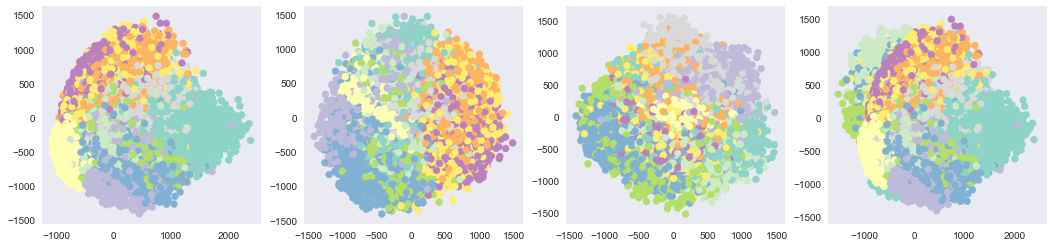

In [11]:
X_pca = df.drop(columns=labels)
pca = PCA(n_components=100)
components = pca.fit_transform(X_pca)
X_pca = pd.DataFrame(components, columns=["col" + str(n) for n in xrange(pca.n_components_)])

num = 4
fig, axes = plt.subplots(1, num, figsize=(18,4))
for i in range (0, num):
    axes[i].scatter(X_pca.iloc[:, i], X_pca.iloc[:, i+1], c=y.values.ravel(), cmap='Set3')

plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c=y.values.ravel(), cmap='Set3')
if (opt_pca_knn):
    X_orig = X
    X = X_pca

## Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Classifier training + predictions & score + cross validation

In [13]:
print "Training classifier..."
if (opt_pca_knn):
    clf = KNeighborsClassifier(n_neighbors=5)
else :
    clf = RandomForestClassifier(n_estimators=64, random_state=128)
clf.fit(X_train, y_train.values.ravel())
score = clf.score(X_test, y_test)
print "- Selected classifier accuracy:", score

print "Computing cross validated scores..."
scores = cross_val_score(clf, X, y.values.ravel(), cv=5)
print "- Cross validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), scores

y_pred = clf.predict(X_test)

Training classifier...
- Selected classifier accuracy: 0.9691666666666666
Computing cross validated scores...
- Cross validated accuracy: 0.97 (+/- 0.01) [0.9718025  0.97036773 0.96797238 0.96474932 0.972606  ]


In [14]:
# Adjustment for plotting results
if (opt_pca_knn):
    X_train = X_orig.iloc[X_train.index]
    X_test  = X_orig.iloc[X_test.index]

## Display image with predicted label

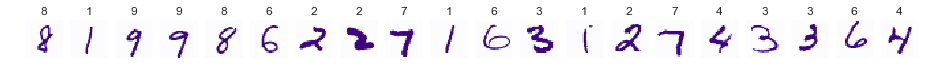

In [15]:
show_imgs(X_test, y_pred)

## Confusion matrix

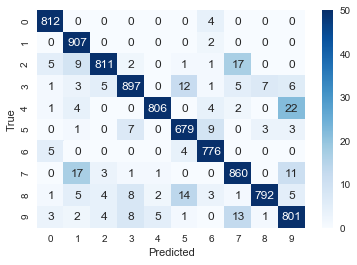

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt='d', vmax=50, cmap="Blues")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Classification report

In [17]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       816
          1       0.96      1.00      0.98       909
          2       0.98      0.96      0.97       846
          3       0.97      0.96      0.96       937
          4       0.99      0.96      0.98       839
          5       0.95      0.97      0.96       702
          6       0.97      0.99      0.98       785
          7       0.96      0.96      0.96       893
          8       0.99      0.95      0.97       835
          9       0.94      0.96      0.95       838

avg / total       0.97      0.97      0.97      8400



## Display misclassifications

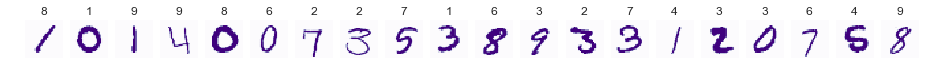

In [18]:
failed = []
for i, (truth, prediction, label) in enumerate(zip(y_test.values.ravel(), y_pred, y.values.ravel())):
    if prediction != label:
        failed.append(i)
df_fail = df.loc[failed].drop(labels, axis=1)

show_imgs(df_fail, y_pred[failed])

In [20]:
# Adjustment for predicting
if (opt_pca_knn):
    X_train = X_pca.iloc[X_train.index]
    X_test  = X_pca.iloc[X_test.index]

## Multiclass ROC curve & AUC

Computing multiple ROC curves...
x


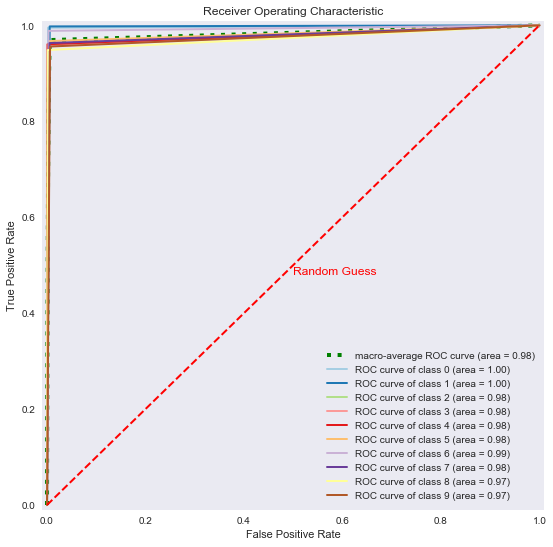

x


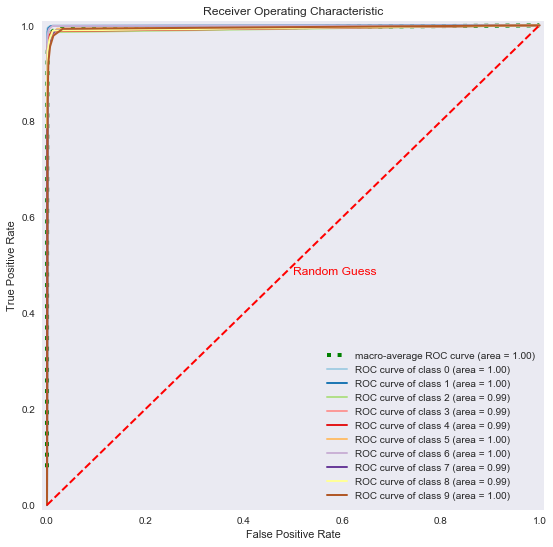

In [22]:
print "Computing multiple ROC curves..."

n_classes = len(clf.classes_)

y_pred_proba = clf.predict_proba(X_test)

y_true  = y_test.values.ravel()
y_true  = np.array(pd.get_dummies(y_true))

y_score = np.array(pd.get_dummies(y_pred))

plot_multiclass_roc_curve(y_true, y_score, n_classes)
plot_multiclass_roc_curve(y_true, y_pred_proba, n_classes)